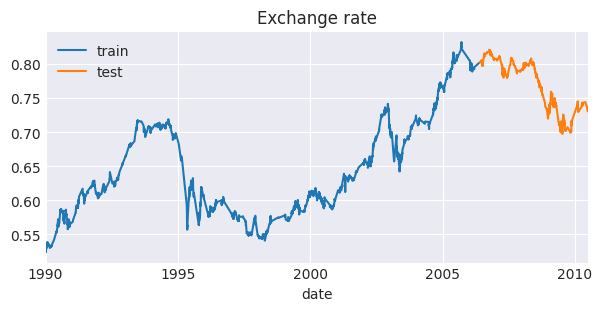

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')


# statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from sklearn.metrics import mean_absolute_error

import warnings



df = pd.read_csv("../data/exchange_rate_with_missing.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df['6'].interpolate(method="linear", direction = "forward", inplace= True)

index = int(len(df) * 0.8)
train_data = df.iloc[:index]
test_data = df.iloc[index:]

fig, ax=plt.subplots(figsize=(7, 3))
train_data['6'].plot(ax=ax, label='train')
test_data['6'].plot(ax=ax, label='test')
ax.set_title('Exchange rate')
ax.legend();

In [2]:
#the kpss and adfuller tests are statistic tests to see weither the data is stationary or not : 
adfuller_result = adfuller(df['6'])
#Since the p-value is greater than the typical significance levels (such as 0.05), we fail to reject the null hypothesis which states that the data is not stationary.
kpss_result = kpss(df['6'])
#the null hypothesis is that the data is stationary. Since the p-value is less than a typical significance level (such as 0.05), we reject the null hypothesis. 
#The results indicate that the data might not be stationary and that there might be trends present
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

ADF Statistic: -1.5126188036614863, p-value: 0.5272600181528201
KPSS Statistic: 8.097740979953766, p-value: 0.01


/tmp/ipykernel_1887/2513271242.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['6'])



Test stationarity for differenced series (order=1)
--------------------------------------------------


/tmp/ipykernel_1887/2543031506.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(train_data['6'].diff().dropna())


ADF Statistic: -17.251995122244953, p-value: 6.0153134954501836e-30
KPSS Statistic: 0.26184264661464257, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------


/tmp/ipykernel_1887/2543031506.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(train_data['6'].diff().diff().dropna())


ADF Statistic: -23.98847790753166, p-value: 0.0
KPSS Statistic: 0.032733320386801025, p-value: 0.1


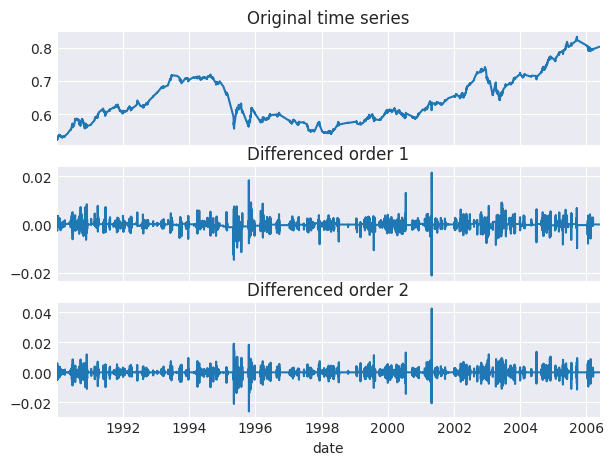

In [4]:
#We look for the "d" parameter value by checking for which differential order the data becomes stationary
data_diff_1 = train_data['6'].diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()
print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(train_data['6'].diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(train_data['6'].diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

#the data shows stationarity from order 1 and above, so we can choose d=1

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
df['6'].plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');

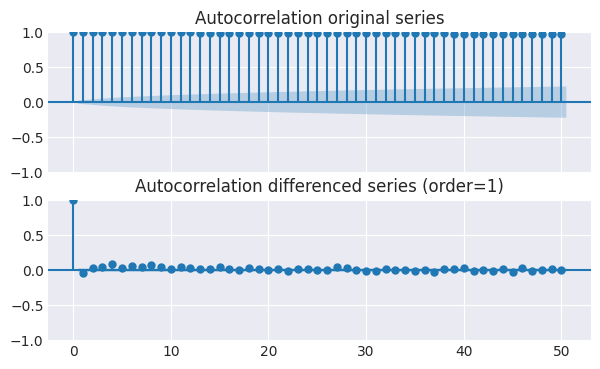

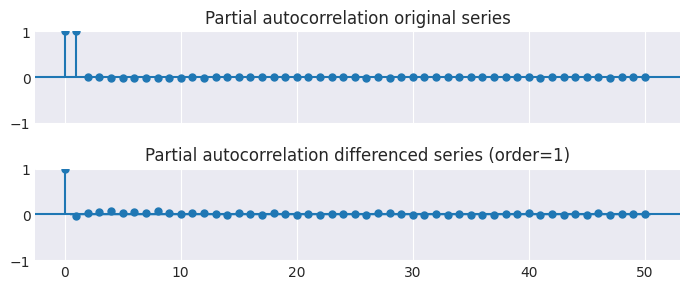

In [5]:
# Create a figure with 2 subplots arranged in 2 rows and 1 column, sharing the x-axis
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
#to determine "q" value
#The lag at which the ACF drops off provides an estimation of the value of q (which is is 0 but we will assign a value of 1 to provide an autoregressive component to the model)

# Plot the ACF for the original series to analyze its autocorrelation structure
plot_acf(df['6'], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')

# Plot the ACF for the differenced series to evaluate stationarity and residual correlations
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)');

# Create another figure with 2 subplots to examine the PACF for "p" value estimation
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
#to determine "p" value
#The lag, at which the PACF drops off, gives an idea of the value of  p (1 in our case)
plot_pacf(df['6'], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout();

In [9]:
model = ARIMA(train_data['6'], order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test_data['6']))
mae = mean_absolute_error(test_data['6'], forecast)
print(mae)

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.03724659330571573


In [48]:
model = ARIMA(df['6'], order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=100)
forecast.to_csv("forecast_results.csv", index=False)
forecast = pd.read_csv("forecast_results.csv")
forecast['ID'] = range(100)
forecast.rename(columns={"predicted_mean": "Prediction"}, inplace=True)
order = ['ID', 'Prediction']
forecast = forecast[order]
forecast.to_csv("predictions.csv", index=False)

forecast.head(10)




/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,ID,Prediction
0,0,0.737259
1,1,0.737253
2,2,0.737252
3,3,0.737252
4,4,0.737252
5,5,0.737252
6,6,0.737252
7,7,0.737252
8,8,0.737252
9,9,0.737252
